### Introduction



This final project explores the best locations for Russian restaurants throughout the city of New York. 

The largest Russian-American communities in New York City are located in Brighton Beach and Sheepshead Bay in Brooklyn. Brighton Beach has been nicknamed Little Odessa due to its population of Russian-speaking immigrants from Ukraine and Russia. The first Russian immigrants to the United States arrived during the late 1800s. During the Russian Revolution of 1917, the "First Wave" of Russians made their way to New York City, most of them moving to Hamilton Heights, Manhattan, and other sections of New York City. The so-called "Third Wave" of Russians were mostly Russian (Soviet) Jews, who migrated during the 1970s to Brighton Beach. Then after this third wave of Russian immigrants, largely Russian Jews, throughout the 1970s Brighton Beach had a re-growth, after being a neglected area of Brooklyn. After the collapse of the Soviet Union in 1991, is the "Fourth Wave" of Russians, with an increase of various ethnic Russians and Russian Christians who immigrated to the United States with the largest number going to the New York metropolitan area. Majority of the Russian Americans who considered Brighton Beach their home, began to migrate out to Suburbia tri state area during the 1990s.

There are already some good Russian restaurants in New York like Farida Central Asian Cuisine & Grill or Russian Samovar Restaurant and Piano Bar, but in this project I will try to explore new opportnities. Especially, today in time of Corona crisis it is possible that some of the exisiting restaurants will go bankrupt, so we have to start exploring these opportunities today in order to open a new Russian restauran after crisis has ended. 

This report explores which neighborhoods and boroughs of New York City have the most as well as the best Russian restaurants. Additionally, I will attempt to answer the questions “Where should I open an Russian Restaurant?” and “Where should I stay If I want good Russian food?”

### Data

In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

All data related to locations and quality of Russian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

First, I explored Foursquare API to find the relevant property. Different categories can be found under: https://developer.foursquare.com/docs/build-with-foursquare/categories/

I will be using the property "Russian Restaurant" without differentiation between Blini House or Pelmeni House:

![%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5.png](attachment:%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5.png)


### Methodology

• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

• FourSquare be used to locate all venues and then filtered by Russian restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Data will be sorted based on rankings

• Finally, the data be will be visually assessed using graphing from various Python libraries.

### Problem Statement


 - What is / are the best location(s) for Russian cuisine in New York City?
 - In what Neighborhood and/or borough should I open an Russian restaurant to have the best chance of being successful?
 - Where would I go in New York City to have the best Russian food?


### Relevant libraries

In [141]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
#!conda install -c conda-forge folium=0.5.0 --yes

import folium 
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

Done!


### My variables

In [142]:
CLIENT_ID = '4VZEJJUEVFILRS54HOI5MUPLVOTPCTRF1GYHYVUEINOCS23M' # your Foursquare ID
CLIENT_SECRET = 'ISCWFC3U0WDKNY4R43JNJVPTG4BFITAOYSDRL5S2YNXCMAOM' # your Foursquare Secret
VERSION = '20200412'
LIMIT = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4VZEJJUEVFILRS54HOI5MUPLVOTPCTRF1GYHYVUEINOCS23M
CLIENT_SECRET:ISCWFC3U0WDKNY4R43JNJVPTG4BFITAOYSDRL5S2YNXCMAOM


### Functions that will be used later

In [143]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=4000
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

### Initial NYC data


In [144]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [145]:
ny_data.shape

(306, 4)

### Data analysis 

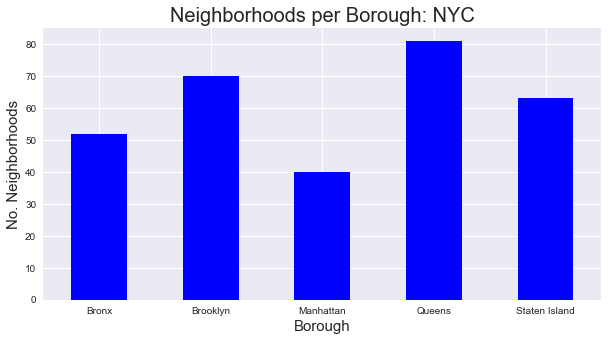

In [146]:
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color="blue")
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

Let's analyze further and see how many Russian restaurants there are in each neighborhood and borough and graph the results.

In [148]:
# Prepare neighborhood list that contains Russian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
russian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    russian_restaurants=venues[venues['Category']=='Russian Restaurant']   
    print('(',count,'/',len(ny_data),')','Russian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(russian_restaurants)))
    print(row)
    for restaurant_detail in russian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        russian_rest_ny = russian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Russian Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Russian Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Russian Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Russian Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Russian Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Russian Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Russian Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Russian Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Russian Restaurants in Norwood, Bronx:0
['

KeyError: 'groups'

In [116]:
russian_rest_ny.to_csv('russian_rest_ny_tocsv2.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [117]:
russian_rest_ny = pd.read_csv('russian_rest_ny_tocsv2.csv')
russian_rest_ny

,Unnamed: 0,Borough,Neighborhood,ID,Name
0,0,Brooklyn,Gravesend,4a2937fcf964a52069951fe3,Stolovaya
1,1,Brooklyn,Gravesend,5a08f7e2d48ec1369706f57d,Bellarussian Xata
2,2,Brooklyn,Gravesend,4ac69109f964a52017b520e3,Skovorodka
3,3,Brooklyn,Gravesend,531d0f0b11d2ad3e0970136a,Village Cafe
4,4,Brooklyn,Brighton Beach,4ac69109f964a52017b520e3,Skovorodka
5,5,Brooklyn,Brighton Beach,5a08f7e2d48ec1369706f57d,Bellarussian Xata
6,6,Brooklyn,Brighton Beach,4a2937fcf964a52069951fe3,Stolovaya
7,7,Brooklyn,Sheepshead Bay,5a08f7e2d48ec1369706f57d,Bellarussian Xata
8,8,Brooklyn,Sheepshead Bay,4ac69109f964a52017b520e3,Skovorodka
9,9,Brooklyn,Sheepshead Bay,4a2937fcf964a52069951fe3,Stolovaya


In [118]:
russian_rest_ny.shape

(42, 5)

The most Russian restaurants can be find in Brooklyn.

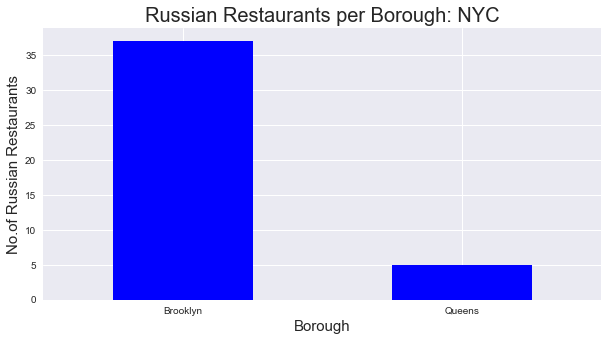

In [119]:
NOofNeigh = 6 
russian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = "blue")
plt.title('Russian Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Russian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

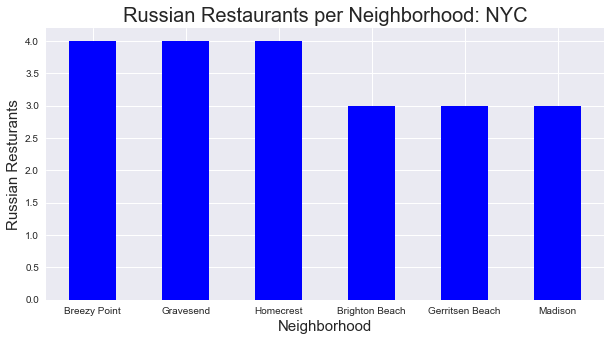

In [120]:
# Let's see ranking of Russian restaurants per Neighborhood

russian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color="blue")
plt.title('Russian Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Russian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()


We can see that Brighton Beach has the most Russian restaurants

In [121]:
russian_rest_ny[russian_rest_ny['Neighborhood']=='Gravesend']

,Unnamed: 0,Borough,Neighborhood,ID,Name
0,0,Brooklyn,Gravesend,4a2937fcf964a52069951fe3,Stolovaya
1,1,Brooklyn,Gravesend,5a08f7e2d48ec1369706f57d,Bellarussian Xata
2,2,Brooklyn,Gravesend,4ac69109f964a52017b520e3,Skovorodka
3,3,Brooklyn,Gravesend,531d0f0b11d2ad3e0970136a,Village Cafe


In [122]:
russian_rest_ny.head()

,Unnamed: 0,Borough,Neighborhood,ID,Name
0,0,Brooklyn,Gravesend,4a2937fcf964a52069951fe3,Stolovaya
1,1,Brooklyn,Gravesend,5a08f7e2d48ec1369706f57d,Bellarussian Xata
2,2,Brooklyn,Gravesend,4ac69109f964a52017b520e3,Skovorodka
3,3,Brooklyn,Gravesend,531d0f0b11d2ad3e0970136a,Village Cafe
4,4,Brooklyn,Brighton Beach,4ac69109f964a52017b520e3,Skovorodka


In [123]:
# Drop first two columns

russian_rest_ny1 = russian_rest_ny.drop(columns=['Unnamed: 0'])

In [124]:
# Reset index

russian_rest_ny = russian_rest_ny1

In [129]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
russian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in russian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(russian_rest_ny),')','processed')
    russian_rest_stats_ny = russian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
russian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5e9a08e3bae9a2001b3b46bc'}, 'response': {'venue': {'id': '4a2937fcf964a52069951fe3', 'name': 'Stolovaya', 'contact': {'phone': '7187870120', 'formattedPhone': '(718) 787-0120'}, 'location': {'address': '813 Avenue U', 'crossStreet': 'btwn 8th & 9th St', 'lat': 40.59819153473893, 'lng': -73.96255456694348, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59819153473893, 'lng': -73.96255456694348}], 'postalCode': '11223', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['813 Avenue U (btwn 8th & 9th St)', 'New York, NY 11223', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/stolovaya/4a2937fcf964a52069951fe3', 'categories': [{'id': '5293a7563cf9994f4e043a44', 'name': 'Russian Restaurant', 'pluralName': 'Russian Restaurants', 'shortName': 'Russian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/russian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'ti

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
37,Brooklyn,Homecrest,531d0f0b11d2ad3e0970136a,Village Cafe,17,7.8,7
38,Brooklyn,Homecrest,4ac69109f964a52017b520e3,Skovorodka,95,8.1,48
39,Brooklyn,Madison,531d0f0b11d2ad3e0970136a,Village Cafe,17,7.8,7
40,Brooklyn,Madison,4a2937fcf964a52069951fe3,Stolovaya,40,8.1,27
41,Brooklyn,Madison,5a08f7e2d48ec1369706f57d,Bellarussian Xata,24,8.7,7


In [130]:
russian_rest_stats_ny.to_csv('russian_rest_stats_ny_csv.csv') # I continue to save data to a .csv as I move through this project

In [131]:
russian_rest_stats_ny.shape

(42, 7)

In [132]:
russian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 7 columns):
Borough         42 non-null object
Neighborhood    42 non-null object
ID              42 non-null object
Name            42 non-null object
Likes           42 non-null object
Rating          42 non-null float64
Tips            42 non-null object
dtypes: float64(1), object(6)
memory usage: 2.4+ KB


In [133]:
russian_rest_stats_ny['Likes']=russian_rest_stats_ny['Likes'].astype('float64')
russian_rest_stats_ny['Tips']=russian_rest_stats_ny['Tips'].astype('float64')
russian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 7 columns):
Borough         42 non-null object
Neighborhood    42 non-null object
ID              42 non-null object
Name            42 non-null object
Likes           42 non-null float64
Rating          42 non-null float64
Tips            42 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.4+ KB


In [134]:
# Some descriptive stats related to our data
russian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,42.000000,42.000000,42.000000
mean,41.547619,8.114286,20.785714
std,29.687151,0.539454,16.812504
min,5.000000,6.000000,3.000000
25%,24.000000,8.100000,7.000000
50%,24.000000,8.100000,7.500000
75%,40.000000,8.700000,27.000000
max,95.000000,8.700000,48.000000


In [135]:
# Restaurant with maximum Likes
russian_rest_stats_ny.iloc[russian_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                   Gravesend
ID              4ac69109f964a52017b520e3
Name                          Skovorodka
Likes                                 95
Rating                               8.1
Tips                                  48
Name: 2, dtype: object

In [136]:
# Restaurant with maximum Ratings
russian_rest_stats_ny.iloc[russian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                   Gravesend
ID              5a08f7e2d48ec1369706f57d
Name                   Bellarussian Xata
Likes                                 24
Rating                               8.7
Tips                                   7
Name: 1, dtype: object

In [137]:
# Restaurant with maximum Tips
russian_rest_stats_ny.iloc[russian_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                   Gravesend
ID              4ac69109f964a52017b520e3
Name                          Skovorodka
Likes                                 95
Rating                               8.1
Tips                                  48
Name: 2, dtype: object

In [138]:
ny_neighborhood_stats=russian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
10,Marine Park,8.400
3,Coney Island,8.400
8,Manhattan Beach,8.300
4,Gerritsen Beach,8.300
16,Sheepshead Bay,8.300
2,Brighton Beach,8.300
7,Madison,8.200
9,Manhattan Terrace,8.200
13,Ocean Parkway,8.200
5,Gravesend,8.175


In [139]:
ny_borough_stats=russian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Brooklyn,8.216216
1,Queens,7.360000


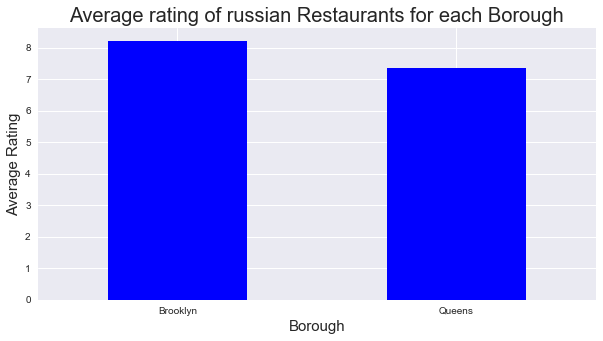

In [140]:
russian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color="blue")
plt.title('Average rating of russian Restaurants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

I will visually map the neighborhoods with an average rating greater than or equal to 8 after joining the approprite dfs to include latitudes and longitudes.

In [149]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bath Beach,8.100
2,Brighton Beach,8.300
3,Coney Island,8.400
4,Gerritsen Beach,8.300
5,Gravesend,8.175
6,Homecrest,8.175
7,Madison,8.200
8,Manhattan Beach,8.300
9,Manhattan Terrace,8.200
10,Marine Park,8.400


In [150]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bath Beach,40.599519,-73.998752,8.100
1,Brooklyn,Brighton Beach,40.576825,-73.965094,8.300
2,Brooklyn,Coney Island,40.574293,-73.988683,8.400
3,Brooklyn,Gerritsen Beach,40.590848,-73.930102,8.300
4,Brooklyn,Gravesend,40.595260,-73.973471,8.175
5,Brooklyn,Homecrest,40.598525,-73.959185,8.175
6,Brooklyn,Madison,40.609378,-73.948415,8.200
7,Brooklyn,Manhattan Beach,40.577914,-73.943537,8.300
8,Brooklyn,Manhattan Terrace,40.614433,-73.957438,8.200
9,Brooklyn,Marine Park,40.609748,-73.931344,8.400


In [151]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )



In [152]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [153]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [154]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Results / Conclusion

Coney Island and Marine Park have the best rated Russian restaurants on average. Gravesend has the highest number of Russian restaurants. The lowest ratings among Russian restaurant have Bath Beach and Sea Gate (8,1 per neighborhood).

As expected, Brooklyn is the borough with the most Russian restaurants due to high number of russian immigrants.

Based on this information, I am ready to answer the questions stated at the beginning: 

1) I would state that Coney Island and Marine Park are the best locations for Russian cuisine in NYC.

2) To have the best shot of success, I would open a Russian restaurant in Sea Gate. It is one of two neighborhoods with the lowest rating (8,1), so competition would be easier than in other neighborhoods. 

3) Finally, I would go to Bellarussian Xata in Gravesend for the best Russian food based on the best overall rating of 8,7.

All of the above analysis is depended on the adequacy and accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.